<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd #импортируем нужные библиотеки
import numpy as np
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet', quiet=True)
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.utils import shuffle


import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('/datasets/toxic_comments.csv',index_col=0)
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Text(0.5, 1.0, 'Распределение значений')

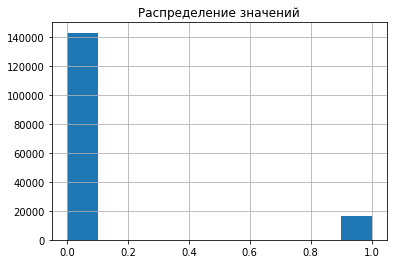

In [3]:
df['toxic'].hist()
plt.title('Распределение значений')

In [4]:
def upsample(features, target, repeat): # напишем функцию upsample для балансировки 
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]  
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat) 
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle( features_upsampled, target_upsampled, random_state=42)
    return features_upsampled, target_upsampled

In [5]:
def cleaning(text): #очистим данные от разделителей и заглавных букв
    text = re.sub(r"(?:\n|\r)", " ", text)
    text = re.sub(r"[^a-zA-Z ]+", "", text).strip()
    text = text.lower()
    return text

df['text'] = df['text'].apply(cleaning)
print(df.text[:10])

0    explanation why the edits made under my userna...
1    daww he matches this background colour im seem...
2    hey man im really not trying to edit war its j...
3    more i cant make any real suggestions on impro...
4    you sir are my hero any chance you remember wh...
5    congratulations from me as well use the tools ...
6         cocksucker before you piss around on my work
7    your vandalism to the matt shirvington article...
8    sorry if the word nonsense was offensive to yo...
9    alignment on this subject and which are contra...
Name: text, dtype: object


In [7]:
from nltk.corpus import wordnet
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [8]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() #проведем лемматиацию
def lemmatize(text):
    words=text.split()
    words=[lemmatizer.lemmatize(word,get_wordnet_pos(word))for word in words]
    return' '.join(words)

In [9]:
#df['text']=df['text'].apply(lambda x:' '.join([lemmatizer.lemmatize(word,get_wordnet_pos(word))for word in x.split()]))
#print(df.text[:10])

In [10]:
target = df['toxic'] #разделим на празнаки и выборки
features = df.drop(['toxic'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.4, 
                                                                              random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
                                                                            target_valid, 
                                                                            test_size=0.5,
                                                                            random_state=12345)


# Применяю функцию upsample
features_up,target_up=upsample(features_train,target_train,repeat=6)


In [11]:
nltk.download('stopwords') #определим стоп слова
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords)

features_train = count_tf_idf.fit_transform(features_train['text']) #посчитаем tf-idf
features_valid = count_tf_idf.transform(features_valid['text'])
features_test = count_tf_idf.transform(features_test['text'])
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)
cv_counts = 3

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(95575, 160208)
(31858, 160208)
(31859, 160208)


Данные загружены . 
Данные готовы к обучению.

## Обучение

In [12]:
#Подберу параметры
#%%time
pipe = Pipeline([
    (
    ('model', LogisticRegression(random_state=1, solver='liblinear', max_iter=200))
    )
    ])


param_grid = [
        {

            'model': [LogisticRegression(random_state=42, solver='liblinear')],
            'model__penalty' : ['l1', 'l2'],
            'model__C': list(range(1,15,3))
        }
]
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='f1', cv=3, verbose=True, n_jobs=-1)
best_grid = grid.fit(features_train, target_train)
print('Best parameters is:', grid.best_params_)
print('Best score is:', grid.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters is: {'model': LogisticRegression(C=4, penalty='l1', random_state=42, solver='liblinear'), 'model__C': 4, 'model__penalty': 'l1'}
Best score is: 0.763573328852393


In [13]:
%%time
params_forest = {
    'n_estimators': list(range(50,300,50)),
    'max_depth':[5,15],
    'max_features' : list(range(1,20, 2))
}


model_forest = RandomForestClassifier(random_state=12345)
                                 
grid = GridSearchCV(model_forest, param_grid=params_forest, scoring='f1', cv=3, verbose=True, n_jobs=-1)
best_grid = grid.fit(features_train, target_train)
print('Best parameters is:', grid.best_params_)
print('Best score is:', grid.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters is: {'max_depth': 5, 'max_features': 1, 'n_estimators': 50}
Best score is: 0.0
CPU times: user 20min 18s, sys: 10.8 s, total: 20min 29s
Wall time: 20min 29s


In [14]:
model = LogisticRegression(random_state=12345, C = 4, penalty = 'l1', solver='liblinear', max_iter=200)#обучим регрессии
model.fit(features_train, target_train)
valid_pred = model.predict(features_valid)
f1_score(target_valid, valid_pred)

0.7904132231404958

In [15]:
from sklearn import metrics

In [16]:
test_pred = model.predict(features_test)
print(metrics.classification_report(target_test, test_pred), metrics.f1_score(target_test, test_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     28639
           1       0.86      0.70      0.77      3220

    accuracy                           0.96     31859
   macro avg       0.92      0.84      0.88     31859
weighted avg       0.96      0.96      0.96     31859
 0.7737727428767592


In [17]:
model_forest = RandomForestClassifier(max_depth=5, max_features=1, n_estimators = 50)
model_forest.fit(features_train, target_train)
valid_pred_f = model_forest.predict(features_valid)
f1_score(target_valid, valid_pred_f)

0.0

## Выводы

Модель обчилась с качесвтом F1=0.78 .

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны